# Imports

In [235]:

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data


# Load datasets

In [236]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [237]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [238]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))



A: 
 136245
Int64Index([118664], dtype='int64')
136244


In [239]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Int64Index([116916], dtype='int64')


134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


# Data clean up

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<AxesSubplot:title={'center':'Target C Clean'}, xlabel='time'>

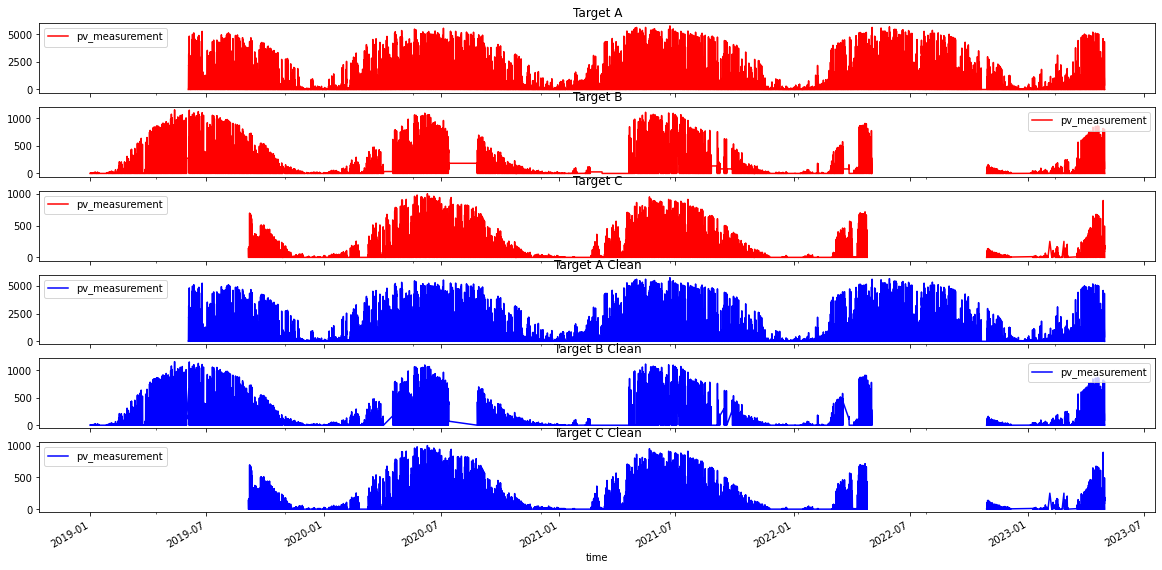

In [240]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



In [241]:
def shift_all_h_columns(df: pd.DataFrame):
    # print length of df before and after
    print("before" + str(len(df)))
    # This functions shifts the given columns by 1.
    columns_to_shift = ['diffuse_rad_1h:J', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'fresh_snow_1h:cm']
    for column in columns_to_shift:
        df[column] = df[column].shift(-4)
    
    print("After" + str(len(df)))
    return df

# Data Aggregation

In [242]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i] = shift_all_h_columns(X_train[i])
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = shift_all_h_columns(X_frames_test[j])
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


before136244
After136244
before134504
After134504
before134400
After134400
before2880
After2880
before2880
After2880
before2880
After2880


In [243]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  34060 34060
x,y:  29596 29596
x,y:  26028 26028


In [244]:
X_train[0].tail()


,date_forecast,dew_or_rime:idx,precip_type_5min:idx,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,estimation_calc_forecast_difference
34055,2023-04-30 19:00:00,0,0,0,1,4.55,1.27650,1674.199951,2270.875,4.225,...,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0,1.0,44545.0
34056,2023-04-30 20:00:00,0,0,0,1,4.50,1.27975,1762.400024,0.000,0.000,...,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0,1.0,48145.0
34057,2023-04-30 21:00:00,0,0,0,1,4.50,1.28100,1696.650024,0.000,0.000,...,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0,1.0,51745.0
34058,2023-04-30 22:00:00,0,0,0,1,4.50,1.28100,1353.400024,0.000,0.000,...,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0,1.0,55345.0
34059,2023-04-30 23:00:00,0,0,0,1,4.50,1.28100,1626.574951,NaN,0.000,...,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0,1.0,58945.0


# Feature engineering

In [245]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DF
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DF.date_forecast_columns(X_frames_test[i])    
 

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


# Data cleaning

In [246]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,6126,4588,5122
clear_sky_energy_1h:J,1,1,1
cloud_base_agl:m,2362,2025,2199
diffuse_rad_1h:J,1,1,1
direct_rad_1h:J,1,1,1
fresh_snow_1h:cm,1,1,1
snow_density:kgm3,32920,28040,24561


In [247]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
clear_sky_energy_1h:J,1,1,1
cloud_base_agl:m,70,65,88
diffuse_rad_1h:J,1,1,1
direct_rad_1h:J,1,1,1
fresh_snow_1h:cm,1,1,1
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720


In [248]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)




In [249]:

print(X_train[0]['estimated'])


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
34055    1.0
34056    1.0
34057    1.0
34058    1.0
34059    1.0
Name: estimated, Length: 34060, dtype: float64


In [250]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
X_train[0].describe().transpose()

X_train[0].head(10)


,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,...,dew_or_rime:idx_1,precip_type_5min:idx_0,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5,msl_pressure:hPa_mean,diffuse_rad:W_mean,diffuse_rad_1h:J_mean,effective_cloud_cover:p_mean
0,0,1,7.700,1.22825,1728.949951,0.000000e+00,0.000000,1728.949951,280.299988,0.000000,...,0,1,0,0,0,0,1001.406311,0.000000,0.000000,99.537498
1,0,1,7.700,1.22350,1689.824951,0.000000e+00,0.000000,1689.824951,280.299988,0.000000,...,0,1,0,0,0,0,1000.293701,0.000000,0.000000,99.875000
2,0,1,7.875,1.21975,1563.224976,2.086500e+02,0.000000,1563.224976,280.649994,0.000000,...,0,1,0,0,0,0,999.612488,0.000000,263.387512,100.000000
3,0,1,8.425,1.21800,1283.425049,3.246815e+04,0.750000,1283.425049,281.674988,0.300000,...,0,1,0,0,0,0,999.106262,0.150000,11175.961914,100.000000
4,1,0,8.950,1.21800,1003.500000,1.794991e+05,23.100000,1003.500000,282.500000,11.975000,...,0,1,0,0,0,0,998.162476,6.062500,57207.796875,92.050003
5,1,0,9.250,1.21650,809.375000,4.781178e+05,84.375000,809.375000,283.049988,45.125000,...,0,1,0,0,0,0,997.368774,25.712500,166255.687500,79.912506
6,1,0,9.525,1.21300,757.775024,8.926679e+05,186.649994,757.775024,283.524994,89.525002,...,0,1,0,0,0,0,996.862488,66.625000,292818.218750,86.324997
7,1,0,9.700,1.20750,705.650024,1.357902e+06,311.525024,705.650024,283.799988,139.000000,...,0,1,0,0,0,0,996.250000,96.050003,353716.875000,91.100006
8,1,0,9.550,1.20500,669.650024,1.821739e+06,442.750000,669.650024,283.600006,167.100006,...,0,1,0,0,0,0,995.843750,100.462502,392642.187500,97.974998
9,1,0,9.450,1.20500,662.224976,2.242189e+06,567.299988,662.224976,283.524994,217.699997,...,0,1,0,0,0,0,995.906250,117.650002,417616.250000,100.000000


In [251]:
# Split the data into training and validation sets

# Convert the data to NumPy arrays or Pandas DataFrames
x_train_np_a = X_train[0].to_numpy()
y_train_np_a = Y_train[0].to_numpy()

x_train_np_b = X_train[1].to_numpy()
y_train_np_b = Y_train[1].to_numpy()

x_train_np_c = X_train[2].to_numpy()
y_train_np_c = Y_train[2].to_numpy()

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(x_train_np_a, y_train_np_a, test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(x_train_np_b, y_train_np_b, test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(x_train_np_c, y_train_np_c, test_size=0.17, random_state=42)

train_data_a = lgb.Dataset(x_train_a, label=y_train_a)
val_data_a = lgb.Dataset(x_val_a, label=y_val_a, reference=train_data_a)


train_data_b = lgb.Dataset(x_train_b, label=y_train_b)
val_data_b = lgb.Dataset(x_val_b, label=y_val_b, reference=train_data_b)

train_data_c = lgb.Dataset(x_train_c, label=y_train_c)
val_data_c = lgb.Dataset(x_val_c, label=y_val_c, reference=train_data_b)



# Training the model

In [252]:
import optuna

def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "mae",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
    }

    num_round = 5000
    model = lgb.train(params, train_data_b, num_round, valid_sets=[val_data_b])

    # Make predictions on the validation set
    y_pred = model.predict(x_val_b)

    # Calculate the Mean Squared Error (MSE) as the metric to optimize
    mae = mean_absolute_error(y_val_b, y_pred)

    return mae

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)

# best = study.best_params
# # Print the best hyperparameters found
# print("Best hyperparameters:", best)


In [253]:


# Use params from hyperparameter tuning using optuna
#params_a = {'objective': 'regression', 'metric': 'mae', 'random_state': 42, 'learning_rate': 0.039975576144155645, 'subsample': 0.4504678933801176, 'min_data_per_group': 90}
params_b = {'objective': 'regression', 'metric': 'mae', 'random_state': 42, 'learning_rate': 0.023765834908014156, 'subsample': 0.8298593330195755, 'min_data_per_group': 61}
params_c = {'objective': 'regression', 'metric': 'mae', 'random_state': 42, 'learning_rate': 0.060183973978509046, 'subsample': 0.28819995411353627, 'min_data_per_group': 77}

# Worse total mae
#params_a = {'learning_rate': 0.0077552659878854695, 'num_leaves': 301, 'subsample': 0.8364547083854652, 'colsample_bytree': 0.7779126979934134, 'min_data_in_leaf': 2}
#params_b = {'learning_rate': 0.03259877684598897, 'num_leaves': 503, 'subsample': 0.6264102340049721, 'colsample_bytree': 0.7566402776599754, 'min_data_in_leaf': 96, 'early_stopping_round': 100}
#params_c = {'learning_rate': 0.004687610647359508, 'num_leaves': 579, 'subsample': 0.31170017054682075, 'colsample_bytree': 0.3204330543358787, 'min_data_in_leaf': 2, 'early_stopping_round': 100}

# new
params_a = {'learning_rate': 0.05747996804710729, 'num_leaves': 128, 'subsample': 0.7682153448307552, 'colsample_bytree': 0.8580675617656637}

# Train the model
num_round = 10000  # You can adjust the number of boosting rounds

# model_a = lgb.LGBMRegressor(**params_a)
# model_b = lgb.LGBMRegressor(**params_b)
# model_c = lgb.LGBMRegressor(**params_c)
model_a = lgb.train(params_a, train_data_a, num_round, valid_sets=[val_data_a])
model_b = lgb.train(params_b, train_data_b, num_round, valid_sets=[val_data_b])
model_c = lgb.train(params_c, train_data_c, num_round, valid_sets=[val_data_c])
# model_a.fit(x_train_a, y_train_a)
# model_b.fit(x_train_b, y_train_b)
# model_c.fit(x_train_c, y_train_c)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10410
[LightGBM] [Info] Number of data points in the train set: 28269, number of used features: 62
[LightGBM] [Info] Start training from score 634.599841
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10435
[LightGBM] [Info] Number of data points in the train set: 24564, number of used features: 62
[LightGBM] [Info] Start training from score 93.842921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10806
[LightGBM] [Info] Number of data points in the train set: 21603, number of used features: 63
[LightGBM] [Info] Sta

In [254]:
y_val_a_pred = model_a.predict(x_val_a)
y_val_b_pred = model_b.predict(x_val_b)
y_val_c_pred = model_c.predict(x_val_c)


# Evaluate prediction

In [255]:
# Evaluate the model based on the validation data

mse_a = mean_squared_error(y_val_a, y_val_a_pred)
print("MSE for A: ", mse_a)
mse_b = mean_squared_error(y_val_b, y_val_b_pred)
print("MSE for B: ", mse_b)
mse_c = mean_squared_error(y_val_c, y_val_c_pred)
print("MSE for C: ", mse_c)
print("Mean MSE: ", (mse_a + mse_b + mse_c) / 3)

#Mean MSE:  41875.359992707075


MSE for A:  112425.54146722716
MSE for B:  2857.872981937607
MSE for C:  1895.7940319946522
Mean MSE:  39059.73616038647


In [256]:
mae_a = mean_absolute_error(y_val_a, y_val_a_pred)
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_val_b, y_val_b_pred)
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_val_c, y_val_c_pred)
print("MAE for C: ", mae_c)
print('total MAE: ', (mae_a + mae_b + mae_c))
print('mean MAE: ', (mae_a + mae_b + mae_c) / 3)

# MAE for A:  148.62609518547382
# MAE for B:  21.461851104498624
# MAE for C:  17.238977268099532
# total MAE:  187.326923558072
# mean MAE:  62.44230785269067

# MAE for A:  158.43262568077435
# MAE for B:  34.02212238854709
# MAE for C:  20.20582499537963
# total MAE:  212.66057306470108
# mean MAE:  70.88685768823369


MAE for A:  146.15943487759893
MAE for B:  20.630946438713746
MAE for C:  17.147466759687408
total MAE:  183.93784807600008
mean MAE:  61.31261602533336


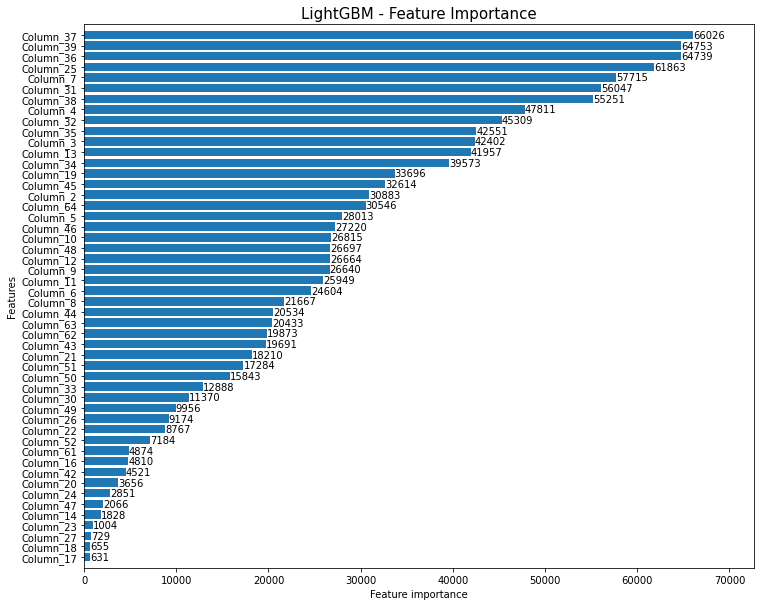

In [257]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model_a, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()


# Make predictions

In [260]:
# Train the model on the entire training data

num_round = 10000  # You can adjust the number of boosting rounds

train_data_a = lgb.Dataset(x_train_np_a, label=y_train_np_a)
train_data_b = lgb.Dataset(x_train_np_b, label=y_train_np_b)
train_data_c = lgb.Dataset(x_train_np_c, label=y_train_np_c)

model_a = lgb.train(params_a, train_data_a, num_round)
model_b = lgb.train(params_b, train_data_b, num_round)
model_c = lgb.train(params_c, train_data_c, num_round)

y_pred_a = model_a.predict(X_frames_test[0]) * X_frames_test[0]['is_day:idx']
y_pred_b = model_b.predict(X_frames_test[1]) * X_frames_test[1]['is_day:idx']
y_pred_c = model_c.predict(X_frames_test[2]) * X_frames_test[2]['is_day:idx']
print(len(y_pred_a))

y_pred = np.concatenate((y_pred_a, y_pred_b, y_pred_c), axis=0)




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10525
[LightGBM] [Info] Number of data points in the train set: 34060, number of used features: 62
[LightGBM] [Info] Start training from score 631.029691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10498
[LightGBM] [Info] Number of data points in the train set: 29596, number of used features: 62
[LightGBM] [Info] Start training from score 93.714218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10847
[LightGBM] [Info] Number of data points in the train set: 26028, number of used features: 63
[LightGBM] [Info] Sta

In [261]:
print(len(y_val_a_pred), len(X_frames_test[0]))
print(len(y_val_b_pred), len(X_frames_test[1]))
print(len(y_val_c_pred), len(X_frames_test[2]))


5791 720
5032 720
4425 720


In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] < 10: 
        y_pred[i] = 0



# Create submission

In [ ]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_lgbm.csv', index=False)
